## Breast cancer Image classification using CNN. CBIS-DDSM dataset
## Pavel Makarov
## 2024-07-06

In [24]:
# Import all necessary libraries
import os
from os import listdir
import pandas as pd
import numpy as np 

# Visualization
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from matplotlib.image import imread


# Image pre-processing and modeling
import torch
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageEnhance
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from torchvision import transforms
import torch
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import glob
import PIL
import random


In [26]:
print(f"os version: {os.__version__ if hasattr(os, '__version__') else 'N/A'}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"cv2 version: {cv2.__version__}")
print(f"tensorflow version: {torch.__version__}")
print(f"PIL version: {Image.__version__}")
print(f"keras version: {keras.__version__}")
print(f"glob version: {glob.__version__ if hasattr(glob, '__version__') else 'N/A'}")
print(f"PIL version: {PIL.__version__}")

os version: N/A
pandas version: 2.2.2
numpy version: 1.26.4
seaborn version: 0.13.2
cv2 version: 4.10.0
tensorflow version: 2.3.0
PIL version: 10.4.0
keras version: 2.13.1
glob version: N/A
PIL version: 10.4.0


### Load the data

In [10]:
# Laod dicom data set
dicom_df = pd.read_csv('csv/dicom_info.csv')

In [12]:
# Show first five rows
dicom_df.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [13]:
# Show the table content and non-null counts
dicom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [16]:
# Load calcification training subset
calc_train_df = pd.read_csv('csv/calc_case_description_train_set.csv')

In [18]:
# Load calcification test subset
calc_test_df = pd.read_csv('csv/calc_case_description_test_set.csv')

In [20]:
# Load mass training subset
mass_train_df = pd.read_csv('csv/mass_case_description_train_set.csv')

In [21]:
# Load mass test subset
mass_test_df = pd.read_csv('csv/mass_case_description_test_set.csv')

In [24]:
# Show calcification training subset information
calc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

In [25]:
# Show calcification test subset information
calc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               326 non-null    object
 1   breast density           326 non-null    int64 
 2   left or right breast     326 non-null    object
 3   image view               326 non-null    object
 4   abnormality id           326 non-null    int64 
 5   abnormality type         326 non-null    object
 6   calc type                322 non-null    object
 7   calc distribution        263 non-null    object
 8   assessment               326 non-null    int64 
 9   pathology                326 non-null    object
 10  subtlety                 326 non-null    int64 
 11  image file path          326 non-null    object
 12  cropped image file path  326 non-null    object
 13  ROI mask file path       326 non-null    object
dtypes: int64(4), object(10)
memory usage: 35.8

In [28]:
# Show mass training subset information
mass_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [29]:
# Show mass test subset information
mass_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               378 non-null    object
 1   breast_density           378 non-null    int64 
 2   left or right breast     378 non-null    object
 3   image view               378 non-null    object
 4   abnormality id           378 non-null    int64 
 5   abnormality type         378 non-null    object
 6   mass shape               378 non-null    object
 7   mass margins             361 non-null    object
 8   assessment               378 non-null    int64 
 9   pathology                378 non-null    object
 10  subtlety                 378 non-null    int64 
 11  image file path          378 non-null    object
 12  cropped image file path  378 non-null    object
 13  ROI mask file path       378 non-null    object
dtypes: int64(4), object(10)
memory usage: 41.5

## EDA and Data Preparation

#### Calcification

In [32]:
# Show first 5 rows of the calcification training susbset
calc_train_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [33]:
# Sum all mising valuies for the training subset
calc_train_df.isna().sum()

patient_id                   0
breast density               0
left or right breast         0
image view                   0
abnormality id               0
abnormality type             0
calc type                   20
calc distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [34]:
# Sum all mising valuies for the test subset
calc_test_df.isna().sum()

patient_id                  0
breast density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
calc type                   4
calc distribution          63
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

#### NOTE: Both training and test datasets will be concatinanted for EDA and data preparation. They can be split before model building.Calcification type and calcification distribution are not critical features for image classification. Missing values in those columns will be filled using fill mode value

In [36]:
# Combine both subsets 
calc_df = pd.concat([calc_train_df, calc_test_df], axis=0)

In [37]:
# Show information for full calcification dataset
calc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1872 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1872 non-null   object
 1   breast density           1872 non-null   int64 
 2   left or right breast     1872 non-null   object
 3   image view               1872 non-null   object
 4   abnormality id           1872 non-null   int64 
 5   abnormality type         1872 non-null   object
 6   calc type                1848 non-null   object
 7   calc distribution        1433 non-null   object
 8   assessment               1872 non-null   int64 
 9   pathology                1872 non-null   object
 10  subtlety                 1872 non-null   int64 
 11  image file path          1872 non-null   object
 12  cropped image file path  1872 non-null   object
 13  ROI mask file path       1872 non-null   object
dtypes: int64(4), object(10)
memory usage: 219.4+ K

In [38]:
# Fill missing values in calcification type feature with the mode value
calc_df.update(calc_df['calc type'].fillna(calc_df['calc type'].mode()[0]))

In [40]:
# Fill missing values in calcification distribution feature with the mode value
calc_df.update(calc_df['calc distribution'].fillna(calc_df['calc distribution'].mode()[0]))

In [41]:
# Check missing values one more time
calc_df.isna().sum()

patient_id                 0
breast density             0
left or right breast       0
image view                 0
abnormality id             0
abnormality type           0
calc type                  0
calc distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [42]:
# Count all target values in calcification data set
calc_pathology_counts = calc_df['pathology'].value_counts()

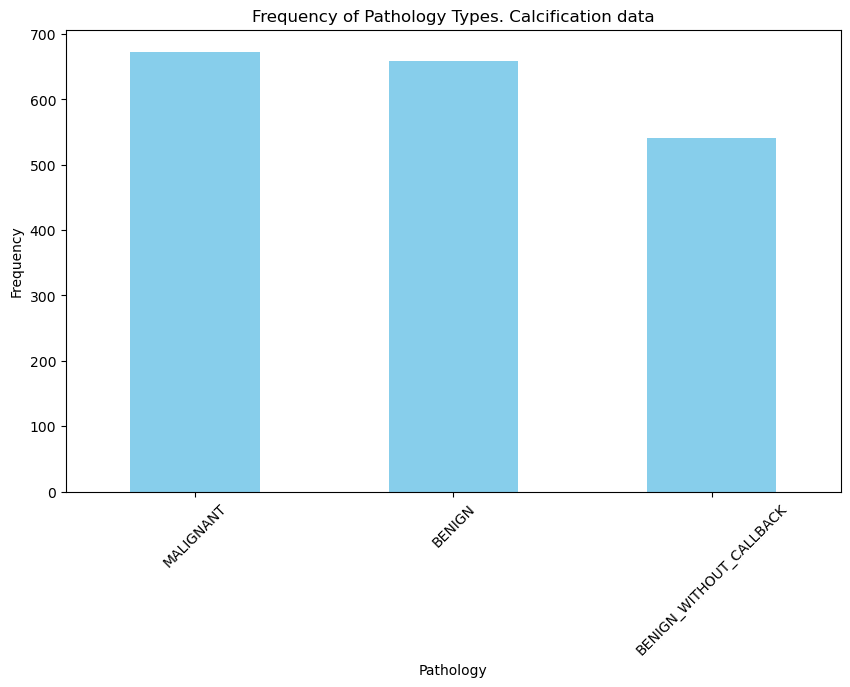

In [43]:
# Plot a bar graph for the target value
plt.figure(figsize=(10, 6))
calc_pathology_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Pathology Types. Calcification data')
plt.xlabel('Pathology')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### NOTE: Since is Benign without callback is technically a benign class they will be mergerd

In [46]:
# Combine benign variation class into one
calc_df['pathology'] = calc_df['pathology'].replace({'BENIGN_WITHOUT_CALLBACK': 'BENIGN'})

In [47]:
# Count the target values after transformation
calc_pathology_counts = calc_df['pathology'].value_counts()

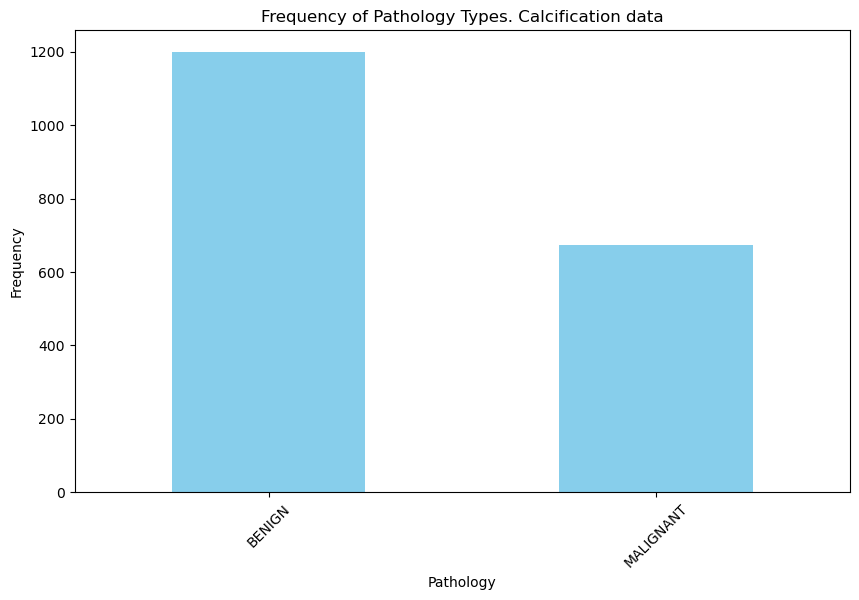

In [48]:
# plot a bar graph of target values
plt.figure(figsize=(10, 6))
calc_pathology_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Pathology Types. Calcification data')
plt.xlabel('Pathology')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### Mass

In [50]:
# Show first 5 rows of mass training subset
mass_train_df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [60]:
# Count missing values for all features in training subset
mass_train_df.isna().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [62]:
# Count missing values for all features in test subset
mass_test_df.isna().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [64]:
# Combine subsets into one
mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

In [67]:
# Check the size of the data set
mass_df.shape

(1696, 14)

In [69]:
# Fill the missing values using features mode
mass_df['mass margins'] = mass_df['mass margins'].fillna(mass_df['mass margins'].mode()[0])


In [70]:
# Count the target values after transformation
mass_pathology_counts = mass_df['pathology'].value_counts()

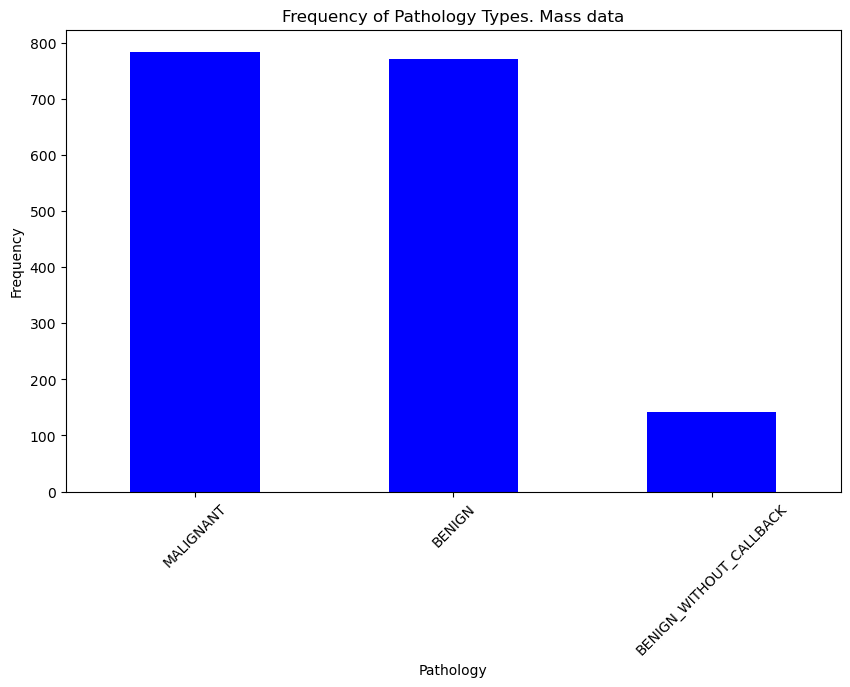

In [71]:
# Build a bar graph
plt.figure(figsize=(10, 6))
mass_pathology_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Pathology Types. Mass data')
plt.xlabel('Pathology')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### NOTE: Since all BENIGN WITHOT CALLBACK values are actually benign, they will be combined under one category

In [73]:
# Combine Benign without callback with benign category
mass_df['pathology'] = mass_df['pathology'].replace({'BENIGN_WITHOUT_CALLBACK': 'BENIGN'})

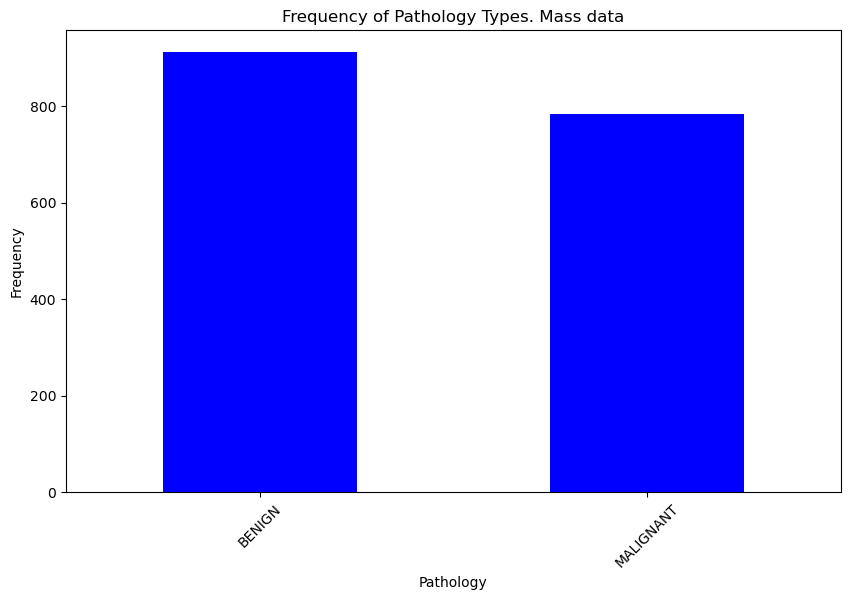

In [74]:
# Build a new bar graph to see the class balances

mass_pathology_counts = mass_df['pathology'].value_counts()
plt.figure(figsize=(10, 6))
mass_pathology_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Pathology Types. Mass data')
plt.xlabel('Pathology')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### NOTE: Both data sets contain important inforamtion about critical atrributes for breast cancer detection. If the target is to detect breast cancer at very early stages then calcification data can be used for training. Mass dataset can be used to train model for breast cancer detection at more advanced stages. It was decided to combine both datasets and develope a model to train on the combined data set. 

In [77]:
# Add a column to indicate the type of abnormality
mass_df['abnormality type'] = 'mass'
calc_df['abnormality type'] = 'calcification'



In [78]:
# Define common columns and unique columns for each dataset
common_columns = ['patient_id', 'breast density', 'left or right breast', 'image view',
                  'abnormality id', 'assessment', 'pathology', 'subtlety', 
                  'image file path', 'cropped image file path', 'ROI mask file path', 
                  'abnormality type']

mass_unique_columns = ['mass shape', 'mass margins']
calc_unique_columns = ['calc type', 'calc distribution']

# Ensure both datasets have the same column names for common attributes
# Rename columns if necessary to match the expected common columns
mass_df.rename(columns={'breast_density': 'breast density'}, inplace=True)
calc_df.rename(columns={'breast_density': 'breast density'}, inplace=True)

# Include unique columns, filling missing values with NaNs
mass_df = mass_df[common_columns + mass_unique_columns]
calc_df = calc_df[common_columns + calc_unique_columns]

# Add missing unique columns to each DataFrame with NaNs
for col in calc_unique_columns:
    mass_df[col] = pd.NA

for col in mass_unique_columns:
    calc_df[col] = pd.NA

# Combine the datasets
combined_df = pd.concat([mass_df, calc_df], ignore_index=True)

# Save the combined dataset if needed
combined_df.to_csv('combined_df.csv', index=False)

combined_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,abnormality type,mass shape,mass margins,calc type,calc distribution
0,P_00001,3,LEFT,CC,1,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,NaN,NaN
1,P_00001,3,LEFT,MLO,1,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,NaN,NaN
2,P_00004,3,LEFT,CC,1,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,NaN,NaN
3,P_00004,3,LEFT,MLO,1,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,NaN,NaN
4,P_00004,3,RIGHT,MLO,1,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,mass,OVAL,CIRCUMSCRIBED,NaN,NaN


In [79]:
# Fill the missing values in the combined dataframe with the mode
combined_df['mass margins'] = combined_df['mass margins'].fillna(combined_df['mass margins'].mode()[0])
combined_df['mass shape'] = combined_df['mass shape'].fillna(combined_df['mass shape'].mode()[0])
combined_df['calc type'] = combined_df['calc type'].fillna(combined_df['calc type'].mode()[0])
combined_df['calc distribution'] = combined_df['calc distribution'].fillna(combined_df['calc distribution'].mode()[0])

In [80]:
# Check the shape
combined_df.shape

(3568, 16)

In [82]:
# Check the inforamtion about the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               3568 non-null   object
 1   breast density           3568 non-null   int64 
 2   left or right breast     3568 non-null   object
 3   image view               3568 non-null   object
 4   abnormality id           3568 non-null   int64 
 5   assessment               3568 non-null   int64 
 6   pathology                3568 non-null   object
 7   subtlety                 3568 non-null   int64 
 8   image file path          3568 non-null   object
 9   cropped image file path  3568 non-null   object
 10  ROI mask file path       3568 non-null   object
 11  abnormality type         3568 non-null   object
 12  mass shape               3568 non-null   object
 13  mass margins             3568 non-null   object
 14  calc type                3568 non-null  

## Assign destination for cropped images using the SeriesDescription columns from dicom_df

In [85]:
# Assign pictures directory
jpeg_dir = 'jpeg/'

In [86]:
# Sort out cropped images paths 
cropped_images = dicom_df[dicom_df.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [88]:
# Replace them with the right directory
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg/', jpeg_dir))
cropped_images.head()

0     jpeg/1.3.6.1.4.1.9590.100.1.2.1293087268128519...
3     jpeg/1.3.6.1.4.1.9590.100.1.2.3811873696115245...
6     jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
7     jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
10    jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...
Name: image_path, dtype: object

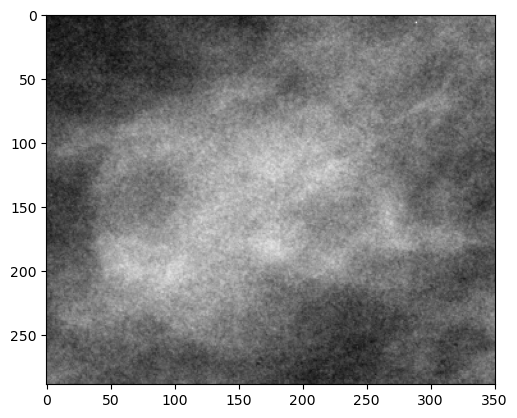

In [89]:
# Open a cropped picture to verify it
for file in cropped_images[0:1]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

## Assign destination for full images using the SeriesDescription columns from dicom_df

In [93]:
# Sort out full images paths 
full_images = dicom_df[dicom_df.SeriesDescription == 'full mammogram images'].image_path
full_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [95]:
# Replace them with the right directory
full_images = full_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg/',jpeg_dir))
full_images.head()

1     jpeg/1.3.6.1.4.1.9590.100.1.2.2483867420106785...
2     jpeg/1.3.6.1.4.1.9590.100.1.2.2672131710111718...
11    jpeg/1.3.6.1.4.1.9590.100.1.2.2103968939112343...
12    jpeg/1.3.6.1.4.1.9590.100.1.2.7495665831138395...
15    jpeg/1.3.6.1.4.1.9590.100.1.2.9876588541294641...
Name: image_path, dtype: object

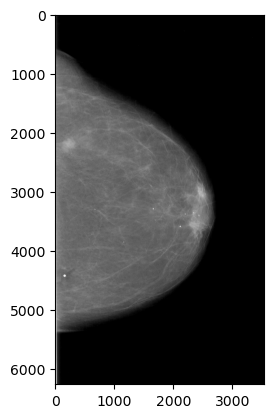

In [96]:
# Open a full picture to verify it
for file  in full_images[0:1]:
    full_images_show = PIL.Image.open(file)
    gray_img= full_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

## Assign destination for ROI images using the SeriesDescription columns from dicom_df

In [101]:
# Sort out ROI mask images paths 
ROI_images = dicom_df[dicom_df.SeriesDescription == 'ROI mask images'].image_path
ROI_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [104]:
# Replace them with the right directory
ROI_images = ROI_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg/', jpeg_dir))
ROI_images.head()

5     jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
8     jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
9     jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...
14    jpeg/1.3.6.1.4.1.9590.100.1.2.2363735487129941...
20    jpeg/1.3.6.1.4.1.9590.100.1.2.3570080504125347...
Name: image_path, dtype: object

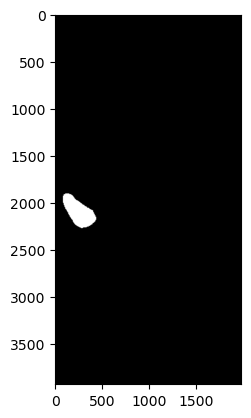

In [106]:
# Open a ROI mask picture to verify it
for file  in ROI_images[0:1]:
    ROI_images_show = PIL.Image.open(file)
    gray_img= ROI_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [107]:
# Check all paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_images.iloc[0])
print('ROI Mask Images paths:\n')
print(ROI_images.iloc[0])

Cropped Images paths:

jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [109]:
# Create dictionaries with the image codes and paths corresponding to full, cropped and ROI mask images
full_mammo_images_dict=dict()
cropped_images_dict=dict()
ROI_mask_images_dict=dict()

for data1 in full_images:
    key=data1.split("/")[1]
    full_mammo_images_dict[key]=data1 
for data1 in cropped_images:
    key=data1.split("/")[1]
    cropped_images_dict[key]=data1   
for data1 in ROI_images:
    key=data1.split("/")[1]
    ROI_mask_images_dict[key]=data1 
    
    
    
# Check items from full image directory
next(iter((full_mammo_images_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 'jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [121]:
# Create a function that takes a dataframe and subsitutes paths to the files with the keys from the corresponding dictionaries
# The function cuts the data for the missing paths 
def FixPaths(data):
    rows_to_drop = []
    
    for i, img in enumerate(data.values):
        # Extract and validate the full image name
        img_name_full = img[8].split("/")[2]
        img_name_cropped = img[9].split("/")[2]
        img_name_ROI = img[10].split("/")[2]
      
        # Check if both keys exist
        if img_name_full in full_mammo_images_dict and img_name_cropped in cropped_images_dict and img_name_ROI in ROI_mask_images_dict:
            data.iloc[i, 8] = full_mammo_images_dict[img_name_full]
            data.iloc[i, 9] = cropped_images_dict[img_name_cropped]
            data.iloc[i, 10] = ROI_mask_images_dict[img_name_ROI]
        else:
            rows_to_drop.append(i)

    
    # Drop rows with missing keys
    data.drop(rows_to_drop, inplace=True)

In [122]:
FixPaths(combined_df)

In [126]:
combined_df.head()


,patient_id,breast density,left or right breast,image view,abnormality id,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,abnormality type,mass shape,mass margins,calc type,calc distribution
0,P_00001,3,LEFT,CC,1,4,MALIGNANT,4,jpeg/1.3.6.1.4.1.9590.100.1.2.3423861948112676...,jpeg/1.3.6.1.4.1.9590.100.1.2.2967364033137925...,jpeg/1.3.6.1.4.1.9590.100.1.2.2967364033137925...,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,PLEOMORPHIC,CLUSTERED
1,P_00001,3,LEFT,MLO,1,4,MALIGNANT,4,jpeg/1.3.6.1.4.1.9590.100.1.2.3593083293123978...,jpeg/1.3.6.1.4.1.9590.100.1.2.2279552747112257...,jpeg/1.3.6.1.4.1.9590.100.1.2.2279552747112257...,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,PLEOMORPHIC,CLUSTERED
2,P_00004,3,LEFT,CC,1,4,BENIGN,3,jpeg/1.3.6.1.4.1.9590.100.1.2.8918004621102253...,jpeg/1.3.6.1.4.1.9590.100.1.2.4291204140118329...,jpeg/1.3.6.1.4.1.9590.100.1.2.4291204140118329...,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,PLEOMORPHIC,CLUSTERED
3,P_00004,3,LEFT,MLO,1,4,BENIGN,3,jpeg/1.3.6.1.4.1.9590.100.1.2.2953609263134927...,jpeg/1.3.6.1.4.1.9590.100.1.2.1151342321130015...,jpeg/1.3.6.1.4.1.9590.100.1.2.1151342321130015...,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,PLEOMORPHIC,CLUSTERED
4,P_00004,3,RIGHT,MLO,1,4,BENIGN,5,jpeg/1.3.6.1.4.1.9590.100.1.2.4105247549130579...,jpeg/1.3.6.1.4.1.9590.100.1.2.1285736631262570...,jpeg/1.3.6.1.4.1.9590.100.1.2.1285736631262570...,mass,OVAL,CIRCUMSCRIBED,PLEOMORPHIC,CLUSTERED


In [128]:
# Check the inforamtion about the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3241 entries, 0 to 3323
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               3241 non-null   object
 1   breast density           3241 non-null   int64 
 2   left or right breast     3241 non-null   object
 3   image view               3241 non-null   object
 4   abnormality id           3241 non-null   int64 
 5   assessment               3241 non-null   int64 
 6   pathology                3241 non-null   object
 7   subtlety                 3241 non-null   int64 
 8   image file path          3241 non-null   object
 9   cropped image file path  3241 non-null   object
 10  ROI mask file path       3241 non-null   object
 11  abnormality type         3241 non-null   object
 12  mass shape               3241 non-null   object
 13  mass margins             3241 non-null   object
 14  calc type                3241 non-null   obje

In [130]:
# Check if the filepaths were properly replaced
print(combined_df['image file path'].head(10))

0    jpeg/1.3.6.1.4.1.9590.100.1.2.3423861948112676...
1    jpeg/1.3.6.1.4.1.9590.100.1.2.3593083293123978...
2    jpeg/1.3.6.1.4.1.9590.100.1.2.8918004621102253...
3    jpeg/1.3.6.1.4.1.9590.100.1.2.2953609263134927...
4    jpeg/1.3.6.1.4.1.9590.100.1.2.4105247549130579...
5    jpeg/1.3.6.1.4.1.9590.100.1.2.3920919319116377...
6    jpeg/1.3.6.1.4.1.9590.100.1.2.1855302201129836...
7    jpeg/1.3.6.1.4.1.9590.100.1.2.3998312421118006...
8    jpeg/1.3.6.1.4.1.9590.100.1.2.3537646332138634...
9    jpeg/1.3.6.1.4.1.9590.100.1.2.3017736959103785...
Name: image file path, dtype: object


In [152]:
benign_ratio = combined_counts['BENIGN']/(combined_counts['BENIGN'] + combined_counts['MALIGNANT'])*100
malig_ratio = combined_counts['MALIGNANT']/(combined_counts['BENIGN'] + combined_counts['MALIGNANT'])*100

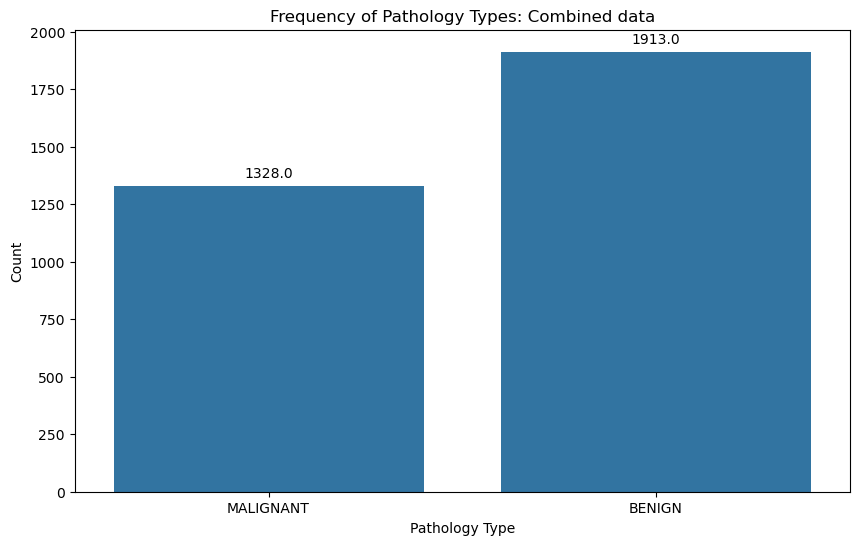

In [176]:
# Plot a bar graph for class balance analysis
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='pathology', data=combined_df, ax=ax)

# Adding labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('Frequency of Pathology Types: Combined data')
plt.xlabel('Pathology Type')
plt.ylabel('Count')
plt.show()

### Data preparation for modeling

In [58]:
# Check the target varibale classes
combined_df['pathology'].unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [59]:
# Create a map for the target variables
mapper={'MALIGNANT': 1, 'BENIGN': 0}

In [60]:
# Apply class mapper to pathology column

combined_df['labels'] = combined_df['pathology'].replace(mapper)

In [61]:
# Define a function that prepares images for neural network training
def ImageProcessor(image_path, target_size):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    image = cv2.resize(image, (target_size[1], target_size[0]))

    pil_image = Image.fromarray(image)

    # Apply enhancements
    pil_image = ImageEnhance.Contrast(pil_image).enhance(1.45)
    pil_image = ImageEnhance.Sharpness(pil_image).enhance(2.5)

    # Convert the PIL image back to a NumPy array
    image_array = np.array(pil_image)

    # Normalize the image array
    augmented_image = image_array / 255.0

    # Add an extra dimension to match the expected input shape (height, width, 1)
    augmented_image = np.expand_dims(augmented_image, axis=-1)

    return augmented_image

In [62]:
def ImageProcessor(image_path, target_size):
    absolute_image_path = tf.io.read_file(image_path)
    image = tf.image.decode_image(absolute_image_path, channels=1)
    image = tf.image.resize(image, target_size[:2])

    # Apply enhancements
    image = tf.image.adjust_contrast(image, 1.45)
    image = tf.image.adjust_brightness(image, 0.1)  # Optional brightness adjustment

    # Normalize the image
    augmented_image = image / 255.0

    # Add an extra dimension
    augmented_image = tf.expand_dims(augmented_image, axis=-1)

    return augmented_image

In [63]:
# Create a function to display images
def display_images(column, number):
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
     
    # Loop through rows and display images
    for index, row in combined_df.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Full Mammograms:



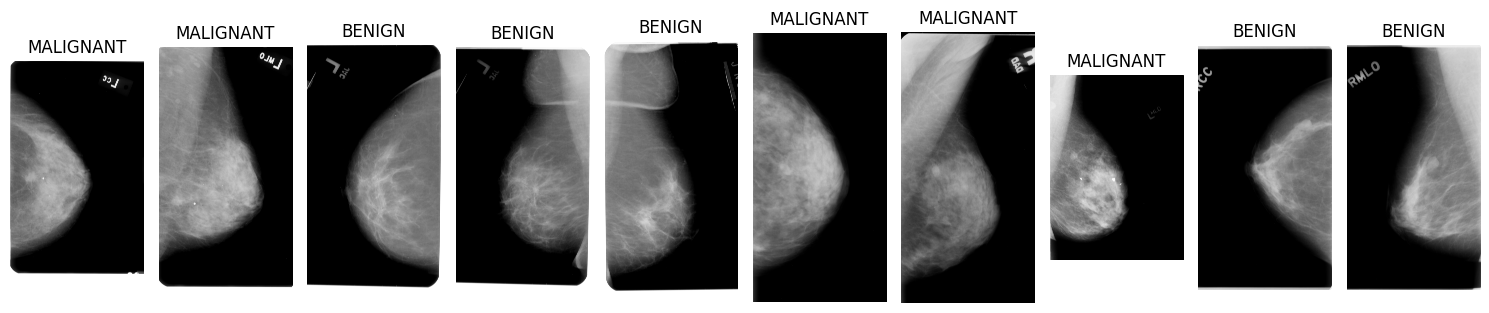

In [64]:
# Print 10 full mammograms
print('Full Mammograms:\n')
display_images('image file path', 10)


Cropped Mammograms:



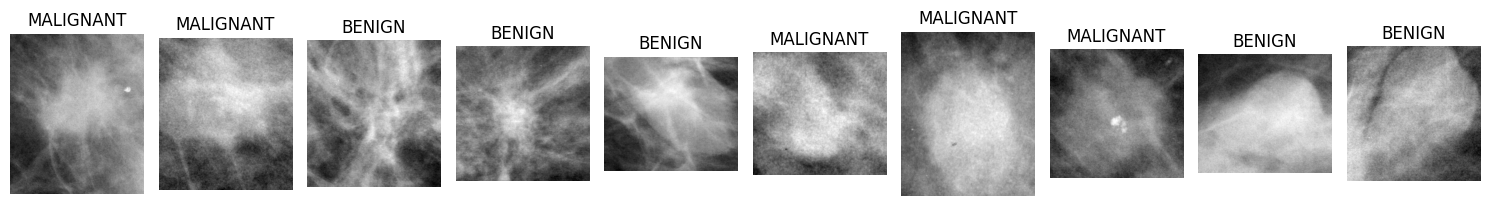

In [65]:
# Print 10 cropped images
print('Cropped Mammograms:\n')
display_images('cropped image file path', 10)

ROI mask:



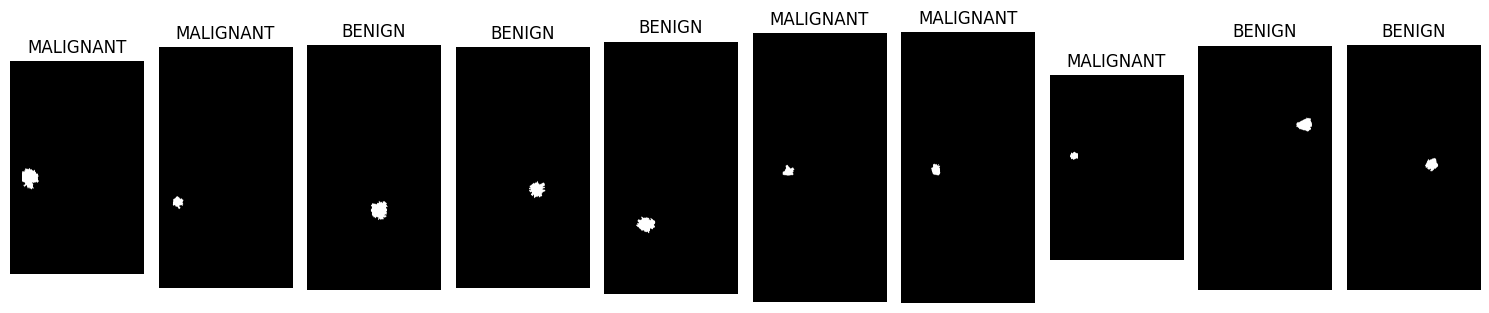

In [66]:
# Print 10 cropped images
print('ROI mask:\n')
display_images('ROI mask file path', 10)

In [67]:
combined_df.dropna(inplace =True)

In [68]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3323
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               3241 non-null   object
 1   breast density           3241 non-null   int64 
 2   left or right breast     3241 non-null   object
 3   image view               3241 non-null   object
 4   abnormality id           3241 non-null   int64 
 5   assessment               3241 non-null   int64 
 6   pathology                3241 non-null   object
 7   subtlety                 3241 non-null   int64 
 8   image file path          3241 non-null   object
 9   cropped image file path  3241 non-null   object
 10  ROI mask file path       3241 non-null   object
 11  abnormality type         3241 non-null   object
 12  mass shape               3241 non-null   object
 13  mass margins             3241 non-null   object
 14  calc type                3241 non-null  

In [69]:
# Reset index of the dataframe
combined_df.reset_index(drop=True, inplace=True)

In [70]:
# Save the combined df
combined_df.to_csv('combined_data_2.csv', index=False)

In [71]:
# Display information about the combined df
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               3241 non-null   object
 1   breast density           3241 non-null   int64 
 2   left or right breast     3241 non-null   object
 3   image view               3241 non-null   object
 4   abnormality id           3241 non-null   int64 
 5   assessment               3241 non-null   int64 
 6   pathology                3241 non-null   object
 7   subtlety                 3241 non-null   int64 
 8   image file path          3241 non-null   object
 9   cropped image file path  3241 non-null   object
 10  ROI mask file path       3241 non-null   object
 11  abnormality type         3241 non-null   object
 12  mass shape               3241 non-null   object
 13  mass margins             3241 non-null   object
 14  calc type                3241 non-null  

In [72]:
# Apply preprocessor to train data
target_size = (224,224,1)
combined_df['processed_images'] = combined_df['image file path'].apply(lambda x: ImageProcessor(x, target_size))


# Process cropped images
combined_df['processed_cropped_images'] = combined_df['cropped image file path'].apply(lambda x: ImageProcessor(x, target_size))

# Process ROI mask images
combined_df['processed_ROI_images'] = combined_df['ROI mask file path'].apply(lambda x: ImageProcessor(x, target_size))

In [73]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [74]:
# Assuming each processed image is grayscale (shape: (height, width, 1))
XX_full = np.array(combined_df['processed_images'].tolist()).reshape(-1, 224, 224, 1)
XX_cropped = np.array(combined_df['processed_cropped_images'].tolist()).reshape(-1, 224, 224, 1)
XX_ROI = np.array(combined_df['processed_ROI_images'].tolist()).reshape(-1, 224, 224, 1)

# Combine them by stacking along the channel dimension
XX_combined = np.concatenate([XX_full, XX_cropped, XX_ROI], axis=-1)  # Shape: (height, width, 3)

# Ensure labels are still available for splitting
labels = combined_df['labels'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    XX_combined, labels, test_size=0.25, random_state=42, stratify=labels
)

In [75]:
XX_combined.shape

(3241, 224, 224, 3)

In [76]:
# Print the shapes of the original data
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2430, 224, 224, 3)
X_test shape: (811, 224, 224, 3)
y_train shape: (2430,)
y_test shape: (811,)


In [77]:
# Assign y_train, y_test to single column version of the targets
y_train_single_col = y_train  
y_test_single_col = y_test  

# Verify the shapes
print("Shape of y_train_single_col:", y_train_single_col.shape) 
print("Shape of y_test_single_col:", y_test_single_col.shape)

Shape of y_train_single_col: (2430,)
Shape of y_test_single_col: (811,)


In [78]:
# Print out inforamtion about classes
print("Training set class distribution:")
print(pd.Series(y_train_single_col).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test_single_col).value_counts())

Training set class distribution:
0    1434
1     996
dtype: int64

Test set class distribution:
0    479
1    332
dtype: int64


In [79]:
# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
num_classes = 2  # Assuming you have 2 classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [80]:
# Verify the shapes after one-hot encoding
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2430, 224, 224, 3)
X_test shape: (811, 224, 224, 3)
y_train shape: (2430, 2)
y_test shape: (811, 2)


In [81]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduce from 90 to 30
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [82]:
# Fit the train and test data
train_datagen = datagen.flow(X_train, y_train, batch_size=16)
test_datagen = datagen.flow(X_test, y_test, batch_size=16, shuffle=False)

In [83]:
print(X_train.shape)
print(X_test.shape)

(2430, 224, 224, 3)
(811, 224, 224, 3)


In [84]:
# Define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True
)

In [85]:
# Assign parameters for early stopping and learning rate threshold when metrics stop improving



In [86]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

In [87]:
# Use pre-trained VGG16 model
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
# Train the model using the generators
history = model.fit(
    train_datagen,
    steps_per_epoch=len(X_train) // 16,
    epochs=40,
    validation_data=test_datagen,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/40
151/151 [==============================] - 33s 118ms/step - loss: 0.8109 - accuracy: 0.5236 - val_loss: 0.6947 - val_accuracy: 0.4112 - lr: 0.0010
Epoch 2/40
151/151 [==============================] - 20s 130ms/step - loss: 0.6899 - accuracy: 0.5302 - val_loss: 0.6888 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 3/40
151/151 [==============================] - 20s 129ms/step - loss: 0.6852 - accuracy: 0.5932 - val_loss: 0.6838 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 4/40
151/151 [==============================] - 19s 128ms/step - loss: 0.6834 - accuracy: 0.5957 - val_loss: 0.6887 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 5/40
151/151 [==============================] - 19s 128ms/step - loss: 0.6787 - accuracy: 0.6102 - val_loss: 0.6805 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 6/40
151/151 [==============================] - 19s 128ms/step - loss: 0.6764 - accuracy: 0.6127 - val_loss: 0.6759 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 7/40
151/151 [==============================] 

In [89]:
# Check the accuracy and the loss of the model 
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

26/26 [==============================] - 3s 63ms/step - loss: 0.6211 - accuracy: 0.6769
Test Loss: 0.6211279034614563
Test Accuracy: 0.6769420504570007


26/26 [==============================] - 1s 45ms/step


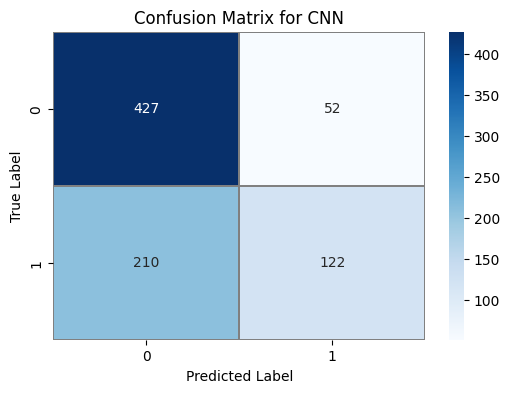

In [95]:
# Generate and plot a confusion matrix for the test set

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, linecolor="gray", fmt='d', cmap="Blues", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN")
plt.show()

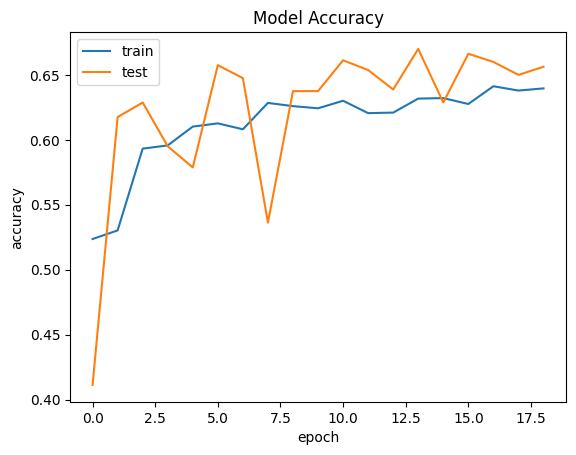

In [96]:
# Generate a line chart for the model accuracy based on the learning history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

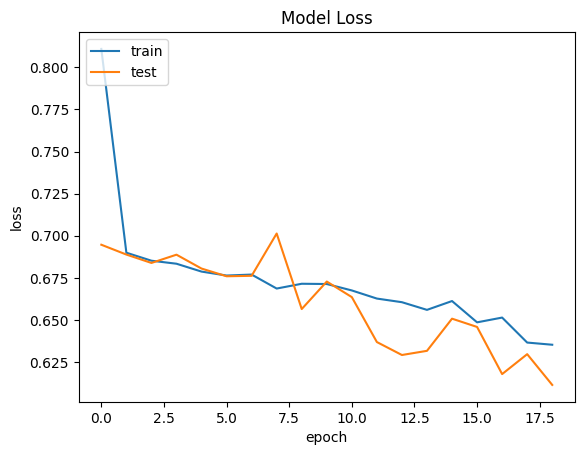

In [97]:
# Generate a line chart for the model loss based on the learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

76/76 [==============================] - 3s 38ms/step
Training Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.70      0.91      0.79      1434
   MALIGNANT       0.76      0.44      0.56       996

    accuracy                           0.71      2430
   macro avg       0.73      0.67      0.67      2430
weighted avg       0.72      0.71      0.69      2430



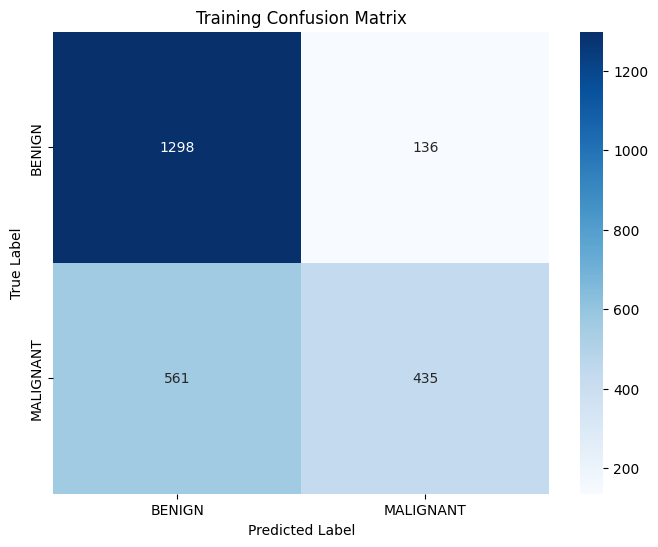

26/26 [==============================] - 1s 38ms/step
Test Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.67      0.89      0.77       479
   MALIGNANT       0.70      0.37      0.48       332

    accuracy                           0.68       811
   macro avg       0.69      0.63      0.62       811
weighted avg       0.68      0.68      0.65       811



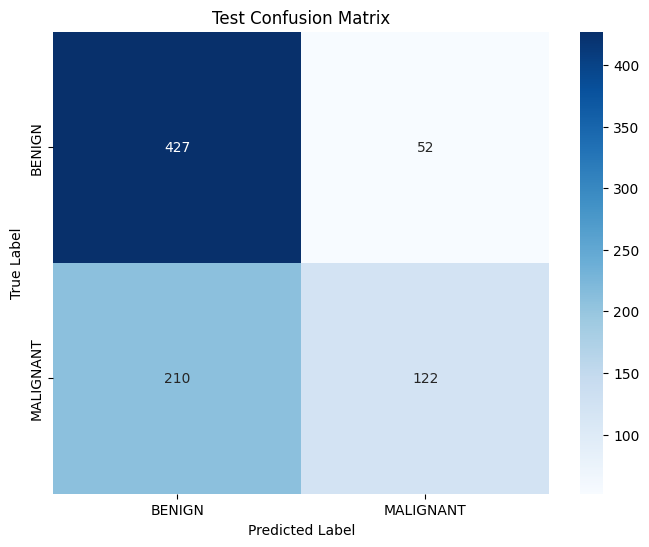

Overall Performance:
accuracy: 0.6951
recall: 0.4021
precision: 0.7315
f1: 0.5187


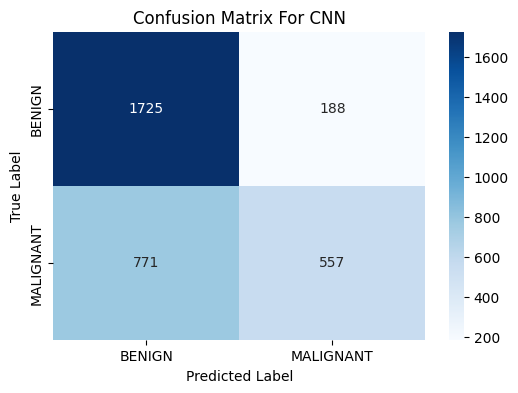

In [98]:


def evaluate_model(model, datasets):
    all_metrics = {}
    all_confusion_matrices = {}
    
    for dataset_type, (X_data, y_data) in datasets.items():
        y_pred = model.predict(X_data)

        # Convert predictions to binary (0 or 1)
        y_pred_binary = np.argmax(y_pred, axis=1)
        y_true_binary = np.argmax(y_data, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        recall = recall_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary)
        f1 = f1_score(y_true_binary, y_pred_binary)
        confusion_mat = confusion_matrix(y_true_binary, y_pred_binary)
        
        all_metrics[dataset_type] = {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}
        all_confusion_matrices[dataset_type] = confusion_mat
        
        # Print classification report
        print(f"{dataset_type} Classification Report:")
        print(classification_report(y_true_binary, y_pred_binary, target_names=["BENIGN", "MALIGNANT"]))
        
        # Plot confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
        plt.title(f"{dataset_type} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    
    # Aggregate confusion matrices for all datasets
    overall_confusion_matrix = sum(all_confusion_matrices.values())
    all_confusion_matrices["Overall"] = overall_confusion_matrix
    
    # Calculate overall performance metrics
    overall_performance = {}
    for metric_name in all_metrics["Training"].keys():
        overall_performance[metric_name] = np.mean([metrics[metric_name] for metrics in all_metrics.values()])
    
    # Print overall performance metrics
    print("Overall Performance:")
    for metric_name, value in overall_performance.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot overall confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(overall_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
    plt.title("Confusion Matrix For CNN")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return all_metrics, all_confusion_matrices

# Usage example
datasets = {"Training": (X_train, y_train), "Test": (X_test, y_test)}
all_metrics, all_confusion_matrices = evaluate_model(model, datasets)

In [99]:
# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

# Calculate precision, recall, and F1 score if desired
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

26/26 [==============================] - 1s 39ms/step - loss: 0.6211 - accuracy: 0.6769
Test Loss: 0.6211279034614563
Test Accuracy: 0.6769420504570007
26/26 [==============================] - 1s 38ms/step
Precision: 0.7011494252873564
Recall: 0.3674698795180723
F1 Score: 0.48221343873517786
